In [28]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [53]:
logs_root = Path("/home/fred/Projects/robin/logs/ethiopia")
# get most recent run
run_dirs = sorted(
    logs_root.iterdir(), key=lambda p: p.stat().st_mtime, reverse=True
)
run_dir = run_dirs[0]
print(f"Using run directory: {run_dir}")
synthetic = pl.read_csv(run_dir / "data" / "synthetic.csv")
latents = pl.read_csv(run_dir / "data" / "zs.csv")

target = pl.read_csv(Path("data/target.csv"))

Using run directory: /home/fred/Projects/robin/logs/ethiopia/ptm8dllm


In [54]:
# controls = ["sex", "age", "denomination"]
# target = pl.read_csv(Path("data/target.csv"))
# synthetic = pl.read_csv(Path("data/synthetic.csv"))
# latents = pl.read_csv(Path("data/zs.csv"))
# synthetic.head()

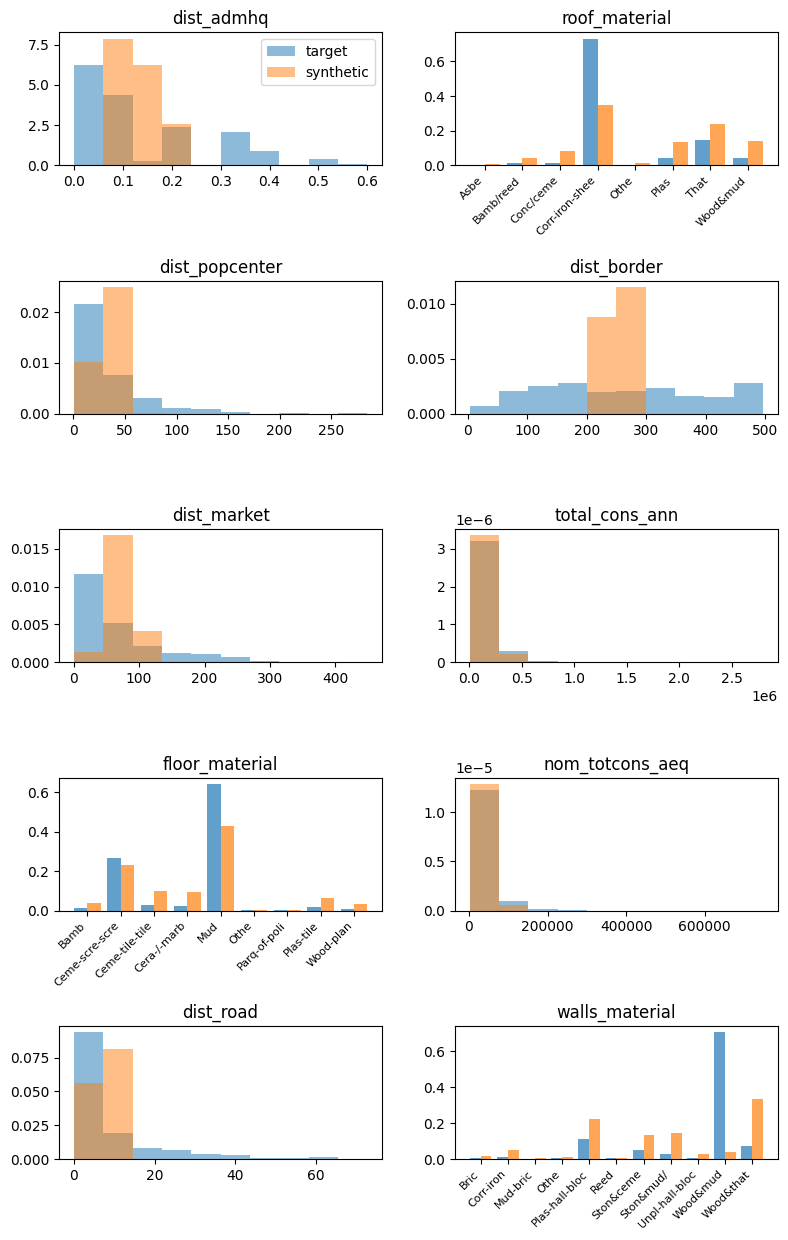

In [55]:
synthetic_cols = list(set(synthetic.columns) - set(controls))

ncols = 2  # change to desired number of columns
nrows = math.ceil(len(synthetic_cols) / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(8, 2.5 * nrows))
axs = axs.flatten()

for i, col in enumerate(synthetic_cols):
    ax = axs[i]
    combined = pl.concat([target[col], synthetic[col]]).to_numpy()

    if combined.dtype in [np.float32, np.float64, float]:  # numerical
        bins = np.histogram_bin_edges(combined.astype(float), bins=10)
        ax.hist(
            target[col].to_numpy().astype(float),
            bins=bins,
            label="target",
            density=True,
            alpha=0.5,
        )
        ax.hist(
            synthetic[col].to_numpy().astype(float),
            bins=bins,
            label="synthetic",
            density=True,
            alpha=0.5,
        )

    else:  # categorical
        cats = np.unique(combined.astype(str))
        cats_short = [
            "-".join([w[:4] for w in cat.split(" ")[:3]]) for cat in cats
        ]
        cats_short = [
            c.replace("-and-", "&").replace("-or-", "/") for c in cats_short
        ]
        t_counts = np.array(
            [(target[col].to_numpy().astype(str) == c).sum() for c in cats]
        ) / len(target)
        s_counts = np.array(
            [(synthetic[col].to_numpy().astype(str) == c).sum() for c in cats]
        ) / len(synthetic)
        x = np.arange(len(cats))
        width = 0.4
        ax.bar(x - width / 2, t_counts, width, alpha=0.7, label="target")
        ax.bar(x + width / 2, s_counts, width, alpha=0.7, label="synthetic")
        ax.set_xticks(x)
        ax.set_xticklabels(cats_short, rotation=45, ha="right", fontsize=8)

    ax.set_title(f"{col}")
    if i == 0:
        ax.legend()

# hide any extra axes
for j in range(len(synthetic_cols), len(axs)):
    axs[j].axis("off")

plt.tight_layout()